### Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

## **Секція 1. Логістична регресія з нуля.**

Будемо крок за кроком будувати модель лог регресії з нуля для передбачення, чи буде врожай більше за 80 яблук (задача подібна до лекційної, але на класифікацію).

Давайте нагадаємо основні формули для логістичної регресії.

#### Функція гіпотези - обчислення передбачення у логістичній регресії:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Де:
- $ \hat{y} $ — це ймовірність "позитивного" класу.
- $ x $ — це вектор (або матриця для набору прикладів) вхідних даних.
- $ W $ — це вектор (або матриця) вагових коефіцієнтів моделі.
- $ b $ — це зміщення (bias).
- $ \sigma(z) $ — це сигмоїдна функція активації.

#### Як обчислюється сигмоїдна функція:

Сигмоїдна функція $ \sigma(z) $ має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Ця функція перетворює будь-яке дійсне значення $ z $ в інтервал від 0 до 1, що дозволяє інтерпретувати вихід як ймовірність для логістичної регресії.

#### Формула функції втрат для логістичної регресії (бінарна крос-ентропія):

Функція втрат крос-ентропії оцінює, наскільки добре модель передбачає класи, порівнюючи передбачені ймовірності $ \hat{y} $ із справжніми мітками $ y $. Формула наступна:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).



### 1. Inputs and targets
Тут вже наведений код для ініціювання набору даних в форматі numpy. Перетворіть `inputs`, `targets` на `torch` тензори. Виведіть результат на екран.

In [2]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

In [3]:
# Transform inputs and targets into tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print("inputs:", inputs)
print("targets:", targets)

inputs: tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
targets: tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


### 2. Weights and biases
Ініціюйте ваги `w`, `b` для моделі логістичної регресії потрібної форми зважаючи на розмірності даних випадковими значеннями з нормального розподілу. Лишаю тут код для фіксації `random_seed`.

In [4]:
torch.random.manual_seed(1)

In [5]:
w = torch.randn(1, 3, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print("weights:", w)
print("biases:", b)

weights: tensor([[0.6614, 0.2669, 0.0617]], requires_grad=True)
biases: tensor([0.6213], requires_grad=True)


### 3. model
Напишіть функцію `model`, яка буде обчислювати функцію гіпотези в логістичній регресії і дозволяти робити передбачення на основі введеного рядка даних і коефіцієнтів в змінних `w`, `b`.

  **Важливий момент**, що функція `model` робить обчислення на `torch.tensors`, тож для математичних обчислень використовуємо функціонал `torch`, наприклад:
  - обчислення $e^x$: `torch.exp(x)`
  - обчислення $log(x)$: `torch.log(x)`
  - обчислення середнього значення вектору `x`: `torch.mean(x)`

  Використайте функцію `model` для обчислення передбачень з поточними значеннями `w`, `b`.Виведіть результат обчислень на екран.

  Проаналізуйте передбачення. Чи не викликають вони у вас підозр? І якщо викликають, то чим це може бути зумовлено?

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

In [6]:
def model(x, w, b):
    return 1 / (1 + torch.exp(-(x @ w.t() + b)))

In [7]:
preds = model(inputs, w, b)
print("predictions:", preds)

predictions: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<MulBackward0>)


With the current initial values of weights and biases, the model always returns 0, 1, or values very close to them. This is due to inappropriate values for `w` and `b`, which result in very large or very small values of `z`.

### 4. `binary_cross_entropy`
Напишіть функцію `binary_cross_entropy`, яка приймає на вхід передбачення моделі `predicted_probs` та справжні мітки в даних `true_labels` і обчислює значення втрат (loss)  за формулою бінарної крос-ентропії для кожного екземпляра та вертає середні втрати по всьому набору даних.
  Використайте функцію `binary_cross_entropy` для обчислення втрат для поточних передбачень моделі.

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$
Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).

In [8]:
def binary_cross_entropy(predicted_proba, true_labels):
    t1 = (true_labels * torch.log(predicted_proba))
    t2 = ((1 - true_labels) * torch.log(1 - predicted_proba))
    return torch.mean(-(t1 + t2))

In [9]:
loss = binary_cross_entropy(preds, targets)
loss

tensor(nan, grad_fn=<MeanBackward0>)

We obtained an infinite loss value because log(0) is undefined (approaches negative infinity for values very close to 0). 

### 5. backward and gradients
Зробіть зворотнє поширення помилки і виведіть градієнти за параметрами `w`, `b`. Проаналізуйте їх значення. Як гадаєте, чому вони саме такі?

In [10]:
loss.backward()

In [11]:
print("w", w)
print("w.grad:", w.grad)

w tensor([[0.6614, 0.2669, 0.0617]], requires_grad=True)
w.grad: tensor([[nan, nan, nan]])


In [12]:
print("b", b)
print("b.grad:", b.grad)

b tensor([0.6213], requires_grad=True)
b.grad: tensor([nan])


For such values of `z` gradients are very close to 0 or undefined.

**Що сталось?**

В цій задачі, коли ми ініціювали значення випадковими значеннями з нормального розподілу, насправді ці значення не були дуже гарними стартовими значеннями і привели до того, що градієнти стали дуже малими або навіть рівними нулю (це призводить до того, що градієнти "зникають"), і відповідно при оновленні ваг у нас не буде нічого змінюватись. Це називається `gradient vanishing`. Це відбувається через **насичення сигмоїдної функції активації.**

У нашій задачі ми використовуємо сигмоїдну функцію активації, яка має такий вигляд:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$


Коли значення $z$ дуже велике або дуже мале, сигмоїдна функція починає "насичуватись". Це означає, що для великих позитивних $z$ сигмоїда наближається до 1, а для великих негативних — до 0. В цих діапазонах градієнти починають стрімко зменшуватись і наближаються до нуля (бо градієнт - це похідна, похідна на проміжку функції, де вона паралельна осі ОХ, дорівнює 0), що робить оновлення ваг неможливим.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

У логістичній регресії $ z = x \cdot w + b $. Якщо ваги $w, b$ - великі, значення $z$ також буде великим, і сигмоїда перейде в насичену область, де градієнти дуже малі.

Саме це сталося в нашій задачі, де великі випадкові значення ваг викликали насичення сигмоїдної функції. Це в свою чергу призводить до того, що під час зворотного поширення помилки (backpropagation) модель оновлює ваги дуже повільно або зовсім не оновлює. Це називається проблемою **зникнення градієнтів** (gradient vanishing problem).

**Що ж робити?**
Ініціювати ваги маленькими значеннями навколо нуля. Наприклад ми можемо просто в існуючій ініціалізації ваги розділити на 1000. Можна також використати інший спосіб ініціалізації вагів - інформація про це [тут](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

Як це робити - показую нижче. **Виконайте код та знову обчисліть передбачення, лосс і виведіть градієнти.**

А я пишу пояснення, чому просто не зробити

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

Нам потрібно, аби тензори вагів були листовими (leaf tensors).

1. **Що таке листовий тензор**
Листовий тензор — це тензор, який був створений користувачем безпосередньо і з якого починається обчислювальний граф. Якщо такий тензор має `requires_grad=True`, PyTorch буде відслідковувати всі операції, виконані над ним, щоб правильно обчислювати градієнти під час навчання.

2. **Чому ми використовуємо `w.data` замість звичайних операцій**
Якщо ми просто виконали б операції, такі як `(w - 0.5) / 100`, ми б отримали **новий тензор**, який вже не був би листовим тензором, оскільки ці операції створюють **новий** тензор, а не модифікують існуючий.

  Проте, щоб залишити наші тензори ваги `w` та зміщення `b` листовими і продовжити можливість відстеження градієнтів під час тренування, ми використовуємо атрибут `.data`. Цей атрибут дозволяє **виконувати операції in-place (прямо на існуючому тензорі)** без зміни самого об'єкта тензора. Отже, тензор залишається листовим, і PyTorch може коректно обчислювати його градієнти.

3. **Чому важливо залишити тензор листовим**
Якщо тензор більше не є листовим (наприклад, через проведення операцій, що створюють нові тензори), ви не зможете отримати градієнти за допомогою `w.grad` чи `b.grad` після виклику `loss.backward()`. Це може призвести до втрати можливості оновлення параметрів під час тренування моделі. В нашому випадку ми хочемо, щоб тензори `w` та `b` накопичували градієнти, тому вони повинні залишатись листовими.

**Висновок:**
Ми використовуємо `.data`, щоб виконати операції зміни значень на ваги і зміщення **in-place**, залишаючи їх листовими тензорами, які можуть накопичувати градієнти під час навчання. Це дозволяє коректно працювати механізму зворотного поширення помилки (backpropagation) і оновлювати ваги моделі.

### 5.2 Initialize weights with `.data`
Виконайте код та знову обчисліть передбачення, лосс і знайдіть градієнти та виведіть всі ці тензори на екран.

In [13]:
torch.random.manual_seed(1)
w = torch.randn(1, 3, requires_grad=True)  # Листовий тензор
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [14]:
print("w:", w)
print("b:", b)

preds = model(inputs, w, b)
print("predictions:", preds)

loss = binary_cross_entropy(preds, targets)
print("loss:", loss)

loss.backward()

print("w.grad:", w.grad)
print("b.grad:", b.grad)


w: tensor([[6.6135e-04, 2.6692e-04, 6.1677e-05]], requires_grad=True)
b: tensor([0.0006], requires_grad=True)
predictions: tensor([[0.5174],
        [0.5220],
        [0.5244],
        [0.5204],
        [0.5190]], grad_fn=<MulBackward0>)
loss: tensor(0.6829, grad_fn=<MeanBackward0>)
w.grad: tensor([[ -5.4417, -18.9853, -10.0682]])
b.grad: tensor([-0.0794])


In this case, the initial value of `w` and `b` are small, resulting in finite loss value and gradients. 

### 6. Gradient descent
Напишіть алгоритм градієнтного спуску, який буде навчати модель з використанням написаних раніше функцій і виконуючи оновлення ваг. Алгоритм має включати наступні кроки:

  1. Генерація прогнозів
  2. Обчислення втрат
  3. Обчислення градієнтів (gradients) loss-функції відносно ваг і зсувів
  4. Налаштування ваг шляхом віднімання невеликої величини, пропорційної градієнту (`learning_rate` домножений на градієнт)
  5. Скидання градієнтів на нуль

Виконайте градієнтний спуск протягом 1000 епох, обчисліть фінальні передбачення і проаналізуйте, чи вони точні?

In [15]:
w = torch.randn(1, 3, requires_grad=True)  # Листовий тензор
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [16]:
epochs = 1000
learning_rate = 1e-5

In [17]:
for i in range(epochs):
    preds = model(inputs, w, b)
    loss = binary_cross_entropy(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * learning_rate
        b -= b.grad * learning_rate
        w.grad.zero_()
        b.grad.zero_()

print("targets:", targets)
preds = model(inputs, w, b)
print("final predictions:", preds)
loss = binary_cross_entropy(preds, targets)
print("final loss:", loss)

targets: tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])
final predictions: tensor([[0.5780],
        [0.6675],
        [0.9129],
        [0.1615],
        [0.8643]], grad_fn=<MulBackward0>)
final loss: tensor(0.3360, grad_fn=<MeanBackward0>)


After 1000 epochs we obtained more appropriate predictions and significantly lower loss value. However, our model still does not perform well, as at the first item is predicted incorrectly.

## **Секція 2. Створення лог регресії з використанням функціоналу `torch.nn`.**

Давайте повторно реалізуємо ту ж модель, використовуючи деякі вбудовані функції та класи з PyTorch.

Даних у нас буде побільше - тож, визначаємо нові масиви.

In [3]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

### 7. TensorDataset
Завантажте вхідні дані та мітки в PyTorch тензори та з них створіть датасет, який поєднує вхідні дані з мітками, використовуючи клас `TensorDataset`. Виведіть перші 3 елементи в датасеті.



In [4]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

train_ds = TensorDataset(inputs, targets)
train_ds[:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[0.],
         [1.],
         [1.]]))

### 8. DataLoader
Визначте data loader з класом **DataLoader** для підготовленого датасету `train_ds`, встановіть розмір батчу на 5 та увімкніть перемішування даних для ефективного навчання моделі. Виведіть перший елемент в дата лоадері.

In [5]:
batch_size = 5
train_loader = DataLoader(train_ds, batch_size, shuffle=True)

In [6]:
next(iter(train_loader))

[tensor([[ 69.,  96.,  70.],
         [ 91.,  88.,  64.],
         [ 69.,  96.,  70.],
         [ 87., 134.,  58.],
         [ 73.,  67.,  43.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]])]

### 9. Class LogReg
Створіть клас `LogReg` для логістичної регресії, наслідуючи модуль `torch.nn.Module` за прикладом в лекції (в частині про FeedForward мережі).

  У нас модель складається з лінійної комбінації вхідних значень і застосування функції сигмоїда. Тож, нейромережа буде складатись з лінійного шару `nn.Linear` і використання активації `nn.Sigmoid`. У створеному класі мають бути реалізовані методи `__init__` з ініціалізацією шарів і метод `forward` для виконання прямого проходу моделі через лінійний шар і функцію активації.

  Створіть екземпляр класу `LogReg` в змінній `model`.

In [7]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        return x

In [8]:
model = LogReg()
model

LogReg(
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (act): Sigmoid()
)

### 10. Stockastic Gradient Descent and binary_cross_entropy
Задайте оптимізатор `Stockastic Gradient Descent` в змінній `opt` для навчання моделі логістичної регресії. А також визначіть в змінній `loss` функцію втрат `binary_cross_entropy` з модуля `torch.nn.functional` для обчислення втрат моделі. Обчисліть втрати для поточних передбачень і міток, а потім виведіть їх. Зробіть висновок, чи моделі вдалось навчитись?

In [9]:
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

loss_fn = F.binary_cross_entropy

In [10]:
loss_fn(model(inputs), targets)

tensor(9.2144, grad_fn=<BinaryCrossEntropyBackward0>)

### 11. Train the model
Візьміть з лекції функцію для тренування моделі з відстеженням значень втрат і навчіть щойно визначену модель на 1000 епохах. Виведіть після цього графік зміни loss, фінальні передбачення і значення таргетів.

In [11]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_loader):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0

        for xb, yb in train_loader:
            pred = model(xb)

            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return losses

In [12]:
num_epochs = 1000

In [13]:
losses = fit_return_loss(num_epochs, model, loss_fn, opt, train_loader)

Epoch [50/1000], Loss: 2.6488
Epoch [100/1000], Loss: 1.3008
Epoch [150/1000], Loss: 0.2830
Epoch [200/1000], Loss: 0.1544
Epoch [250/1000], Loss: 0.1515
Epoch [300/1000], Loss: 0.1511
Epoch [350/1000], Loss: 0.1513
Epoch [400/1000], Loss: 0.1504
Epoch [450/1000], Loss: 0.1500
Epoch [500/1000], Loss: 0.1497
Epoch [550/1000], Loss: 0.1499
Epoch [600/1000], Loss: 0.1490
Epoch [650/1000], Loss: 0.1486
Epoch [700/1000], Loss: 0.1487
Epoch [750/1000], Loss: 0.1483
Epoch [800/1000], Loss: 0.1474
Epoch [850/1000], Loss: 0.1473
Epoch [900/1000], Loss: 0.1475
Epoch [950/1000], Loss: 0.1466
Epoch [1000/1000], Loss: 0.1462


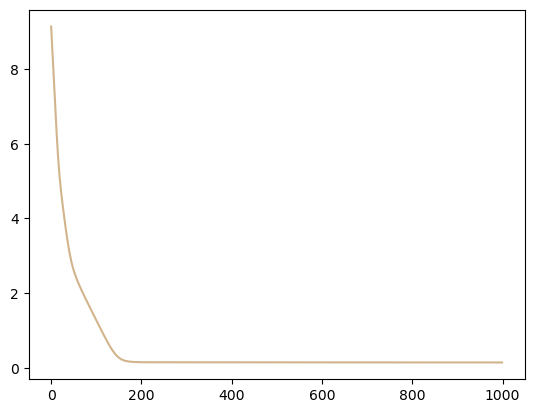

In [14]:
plt.plot(losses, color='tan')
plt.show()

In [32]:
model(inputs).round()

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

In [17]:
targets

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])

The model performs well, and 200 epochs are sufficient to achieve these results.